In [2]:
import mplsoccer as mpl
import numpy as np 
import pandas as pd
import json
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.lines as lines

In [ ]:
query = '''
with epl as (
SELECT
  Minute,
  Second,
  MatchId,
  TeamId,
  PlayerId,
  X,
  Y,
  Type,
  OutcomeType,
  Qualifiers,
  SatisfiedEventsTypes,
  PassEndX,
  PassEndY,
  Length,
  Angle,
  LAG(PlayerId)
    OVER (PARTITION BY MatchId ORDER BY Minute, Second ASC) as Passed_from,
  LEAD(PlayerId)
    OVER (PARTITION BY MatchId ORDER BY Minute, Second ASC) as Passed_to
FROM
  `DATASET.Event_Data.World_Cup_2022`)

SELECT 
  epl.Minute,
  epl.Second,
  epl.MatchId,
  epl.TeamId,
  epl.PlayerId,
  players.player as Player,
  epl.X,
  epl.Y,
  epl.Type,
  epl.OutcomeType,
  epl.Qualifiers,
  epl.SatisfiedEventsTypes,
  eventlookup.Event,
  epl.PassEndX,
  epl.PassEndY,
  epl.Length,
  epl.Angle,
  players1.player as Passed_From,
  players2.player as Passed_To

FROM 
epl,

UNNEST(epl.SatisfiedEventsTypes) as EventTypes,
UNNEST(epl.Qualifiers) as Qualifiers

LEFT JOIN 
  `DATASET.Lookup_Tables.Players` as players ON epl.PlayerId = players.id
LEFT JOIN 
  `DATASET.Lookup_Tables.Event_Types` as eventlookup ON EventTypes = eventlookup.Id
LEFT JOIN 
  `DATASET.Lookup_Tables.Qualifiers` as qlookup ON Qualifiers = qlookup.Id

LEFT JOIN 
  `DATASET.Lookup_Tables.Players` as players1 ON epl.Passed_from= players1.id 

LEFT JOIN 
  `DATASET.Lookup_Tables.Players` as players2 ON epl.Passed_to = players2.id


LEFT JOIN 
  `DATASET.Lookup_Tables.Teams` as teams ON epl.TeamId = teams.id

WHERE 
PlayerId is not NULL AND
TYPE = 'Pass' AND
OutcomeType = True

'''

df = pd.read_gbq(query, project_id='DATASET').drop_duplicates()

In [3]:
xt_grid = np.array(pd.read_json('https://karun.in/blog/data/open_xt_12x8_v1.json'))

In [4]:
xT_rows, xT_cols = xt_grid.shape
df['x1_bin'] = pd.cut(df['X'], bins=xT_cols, labels=False)
df['y1_bin'] = pd.cut(df['Y'], bins=xT_rows, labels=False)
df['x2_bin'] = pd.cut(df['PassEndX'], bins=xT_cols, labels=False)
df['y2_bin'] = pd.cut(df['PassEndY'], bins=xT_rows, labels=False)
df['start_zone_value'] = df[['x1_bin', 'y1_bin']].apply(lambda x: xt_grid[x[1]][x[0]], axis=1)
df['end_zone_value'] = df[['x2_bin', 'y2_bin']].apply(lambda x: xt_grid[x[1]][x[0]], axis=1)
df['xT'] = df['end_zone_value'] - df['start_zone_value']
df = df.drop(['x1_bin', 'y1_bin','x2_bin', 'y2_bin','start_zone_value','end_zone_value' ],axis=1)

In [5]:
ys = [  0. ,  21.1,  36.8,  63.2,  78.9, 100. ] #original coordinate system
xs = [50. ,  66.5,  83. , 100. ]
df['X_bin'] = pd.cut(df['X'], xs,labels=False)
df['Y_bin'] = pd.cut(df['Y'], ys,labels=False)

In [6]:
agg = pd.DataFrame()
#for text
x_text = [59, 75.3, 92]
y_text = (np.array(ys)[1:] + np.array(ys)[:-1]) / 2
for i in range(0,len(xs[:-1])):
    for j in range(0, len(ys[:-1])):
        temp = df[(df['X_bin'] == i) & (df['Y_bin']== j)]
        temp = temp.groupby(['Player','X_bin','Y_bin'],as_index=False).sum('xT').sort_values('xT',ascending=False).head(1)
        temp['y_coord'] = x_text[i] #swapped only here
        temp['x_coord'] = y_text[j] #change here
        agg = pd.concat([agg,temp])
agg = agg[(agg['X_bin'] != 2) | (agg['Y_bin'] != 2)] #delete center

In [7]:
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch ,Pitch
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import urllib
from highlight_text import HighlightText, ax_text, fig_text
from imageio.v3 import imread

In [8]:
flag_lookup = {
    "ad": "Andorra",
    "ae": "United Arab Emirates",
    "af": "Afghanistan",
    "ag": "Antigua and Barbuda",
    "ai": "Anguilla",
    "al": "Albania",
    "am": "Armenia",
    "ao": "Angola",
    "aq": "Antarctica",
    "ar": "Argentina",
    "as": "American Samoa",
    "at": "Austria",
    "au": "Australia",
    "aw": "Aruba",
    "ax": "Åland Islands",
    "az": "Azerbaijan",
    "ba": "Bosnia and Herzegovina",
    "bb": "Barbados",
    "bd": "Bangladesh",
    "be": "Belgium",
    "bf": "Burkina Faso",
    "bg": "Bulgaria",
    "bh": "Bahrain",
    "bi": "Burundi",
    "bj": "Benin",
    "bl": "Saint Barthélemy",
    "bm": "Bermuda",
    "bn": "Brunei",
    "bo": "Bolivia",
    "bq": "Caribbean Netherlands",
    "br": "Brazil",
    "bs": "Bahamas",
    "bt": "Bhutan",
    "bv": "Bouvet Island",
    "bw": "Botswana",
    "by": "Belarus",
    "bz": "Belize",
    "ca": "Canada",
    "cc": "Cocos (Keeling) Islands",
    "cd": "DR Congo",
    "cf": "Central African Republic",
    "cg": "Republic of the Congo",
    "ch": "Switzerland",
    "ci": "Côte d'Ivoire (Ivory Coast)",
    "ck": "Cook Islands",
    "cl": "Chile",
    "cm": "Cameroon",
    "cn": "China",
    "co": "Colombia",
    "cr": "Costa Rica",
    "cu": "Cuba",
    "cv": "Cape Verde",
    "cw": "Curaçao",
    "cx": "Christmas Island",
    "cy": "Cyprus",
    "cz": "Czechia",
    "de": "Germany",
    "dj": "Djibouti",
    "dk": "Denmark",
    "dm": "Dominica",
    "do": "Dominican Republic",
    "dz": "Algeria",
    "ec": "Ecuador",
    "ee": "Estonia",
    "eg": "Egypt",
    "eh": "Western Sahara",
    "er": "Eritrea",
    "es": "Spain",
    "et": "Ethiopia",
    "eu": "European Union",
    "fi": "Finland",
    "fj": "Fiji",
    "fk": "Falkland Islands",
    "fm": "Micronesia",
    "fo": "Faroe Islands",
    "fr": "France",
    "ga": "Gabon",
    "gb": "United Kingdom",
    "gb-eng": "England",
    "gb-nir": "Northern Ireland",
    "gb-sct": "Scotland",
    "gb-wls": "Wales",
    "gd": "Grenada",
    "ge": "Georgia",
    "gf": "French Guiana",
    "gg": "Guernsey",
    "gh": "Ghana",
    "gi": "Gibraltar",
    "gl": "Greenland",
    "gm": "Gambia",
    "gn": "Guinea",
    "gp": "Guadeloupe",
    "gq": "Equatorial Guinea",
    "gr": "Greece",
    "gs": "South Georgia",
    "gt": "Guatemala",
    "gu": "Guam",
    "gw": "Guinea-Bissau",
    "gy": "Guyana",
    "hk": "Hong Kong",
    "hm": "Heard Island and McDonald Islands",
    "hn": "Honduras",
    "hr": "Croatia",
    "ht": "Haiti",
    "hu": "Hungary",
    "id": "Indonesia",
    "ie": "Ireland",
    "il": "Israel",
    "im": "Isle of Man",
    "in": "India",
    "io": "British Indian Ocean Territory",
    "iq": "Iraq",
    "ir": "Iran",
    "is": "Iceland",
    "it": "Italy",
    "je": "Jersey",
    "jm": "Jamaica",
    "jo": "Jordan",
    "jp": "Japan",
    "ke": "Kenya",
    "kg": "Kyrgyzstan",
    "kh": "Cambodia",
    "ki": "Kiribati",
    "km": "Comoros",
    "kn": "Saint Kitts and Nevis",
    "kp": "North Korea",
    "kr": "South Korea",
    "kw": "Kuwait",
    "ky": "Cayman Islands",
    "kz": "Kazakhstan",
    "la": "Laos",
    "lb": "Lebanon",
    "lc": "Saint Lucia",
    "li": "Liechtenstein",
    "lk": "Sri Lanka",
    "lr": "Liberia",
    "ls": "Lesotho",
    "lt": "Lithuania",
    "lu": "Luxembourg",
    "lv": "Latvia",
    "ly": "Libya",
    "ma": "Morocco",
    "mc": "Monaco",
    "md": "Moldova",
    "me": "Montenegro",
    "mf": "Saint Martin",
    "mg": "Madagascar",
    "mh": "Marshall Islands",
    "mk": "North Macedonia",
    "ml": "Mali",
    "mm": "Myanmar",
    "mn": "Mongolia",
    "mo": "Macau",
    "mp": "Northern Mariana Islands",
    "mq": "Martinique",
    "mr": "Mauritania",
    "ms": "Montserrat",
    "mt": "Malta",
    "mu": "Mauritius",
    "mv": "Maldives",
    "mw": "Malawi",
    "mx": "Mexico",
    "my": "Malaysia",
    "mz": "Mozambique",
    "na": "Namibia",
    "nc": "New Caledonia",
    "ne": "Niger",
    "nf": "Norfolk Island",
    "ng": "Nigeria",
    "ni": "Nicaragua",
    "nl": "Netherlands",
    "no": "Norway",
    "np": "Nepal",
    "nr": "Nauru",
    "nu": "Niue",
    "nz": "New Zealand",
    "om": "Oman",
    "pa": "Panama",
    "pe": "Peru",
    "pf": "French Polynesia",
    "pg": "Papua New Guinea",
    "ph": "Philippines",
    "pk": "Pakistan",
    "pl": "Poland",
    "pm": "Saint Pierre and Miquelon",
    "pn": "Pitcairn Islands",
    "pr": "Puerto Rico",
    "ps": "Palestine",
    "pt": "Portugal",
    "pw": "Palau",
    "py": "Paraguay",
    "qa": "Qatar",
    "re": "Réunion",
    "ro": "Romania",
    "rs": "Serbia",
    "ru": "Russia",
    "rw": "Rwanda",
    "sa": "Saudi Arabia",
    "sb": "Solomon Islands",
    "sc": "Seychelles",
    "sd": "Sudan",
    "se": "Sweden",
    "sg": "Singapore",
    "sh": "Saint Helena, Ascension and Tristan da Cunha",
    "si": "Slovenia",
    "sj": "Svalbard and Jan Mayen",
    "sk": "Slovakia",
    "sl": "Sierra Leone",
    "sm": "San Marino",
    "sn": "Senegal",
    "so": "Somalia",
    "sr": "Suriname",
    "ss": "South Sudan",
    "st": "São Tomé and Príncipe",
    "sv": "El Salvador",
    "sx": "Sint Maarten",
    "sy": "Syria",
    "sz": "Eswatini (Swaziland)",
    "tc": "Turks and Caicos Islands",
    "td": "Chad",
    "tf": "French Southern and Antarctic Lands",
    "tg": "Togo",
    "th": "Thailand",
    "tj": "Tajikistan",
    "tk": "Tokelau",
    "tl": "Timor-Leste",
    "tm": "Turkmenistan",
    "tn": "Tunisia",
    "to": "Tonga",
    "tr": "Turkey",
    "tt": "Trinidad and Tobago",
    "tv": "Tuvalu",
    "tw": "Taiwan",
    "tz": "Tanzania",
    "ua": "Ukraine",
    "ug": "Uganda",
    "um": "United States Minor Outlying Islands",
    "un": "United Nations",
    "us": "United States",
    "us-ak": "Alaska",
    "us-al": "Alabama",
    "us-ar": "Arkansas",
    "us-az": "Arizona",
    "us-ca": "California",
    "us-co": "Colorado",
    "us-ct": "Connecticut",
    "us-de": "Delaware",
    "us-fl": "Florida",
    "us-ga": "Georgia",
    "us-hi": "Hawaii",
    "us-ia": "Iowa",
    "us-id": "Idaho",
    "us-il": "Illinois",
    "us-in": "Indiana",
    "us-ks": "Kansas",
    "us-ky": "Kentucky",
    "us-la": "Louisiana",
    "us-ma": "Massachusetts",
    "us-md": "Maryland",
    "us-me": "Maine",
    "us-mi": "Michigan",
    "us-mn": "Minnesota",
    "us-mo": "Missouri",
    "us-ms": "Mississippi",
    "us-mt": "Montana",
    "us-nc": "North Carolina",
    "us-nd": "North Dakota",
    "us-ne": "Nebraska",
    "us-nh": "New Hampshire",
    "us-nj": "New Jersey",
    "us-nm": "New Mexico",
    "us-nv": "Nevada",
    "us-ny": "New York",
    "us-oh": "Ohio",
    "us-ok": "Oklahoma",
    "us-or": "Oregon",
    "us-pa": "Pennsylvania",
    "us-ri": "Rhode Island",
    "us-sc": "South Carolina",
    "us-sd": "South Dakota",
    "us-tn": "Tennessee",
    "us-tx": "Texas",
    "us-ut": "Utah",
    "us-va": "Virginia",
    "us-vt": "Vermont",
    "us-wa": "Washington",
    "us-wi": "Wisconsin",
    "us-wv": "West Virginia",
    "us-wy": "Wyoming",
    "uy": "Uruguay",
    "uz": "Uzbekistan",
    "va": "Vatican City (Holy See)",
    "vc": "Saint Vincent and the Grenadines",
    "ve": "Venezuela",
    "vg": "British Virgin Islands",
    "vi": "United States Virgin Islands",
    "vn": "Vietnam",
    "vu": "Vanuatu",
    "wf": "Wallis and Futuna",
    "ws": "Samoa",
    "xk": "Kosovo",
    "ye": "Yemen",
    "yt": "Mayotte",
    "za": "South Africa",
    "zm": "Zambia",
    "zw": "Zimbabwe"
}

flag_lookup = {v:k for k,v in flag_lookup.items()}

In [9]:
FONTSIZE = 7
TITLE_SIZE = 20
SUBTITLE_SIZE = 10
CREDIT_SIZE = 6
TITLEFONT ='Helvetica'
FONT = 'Roboto'
HIGHLIGHT ='#E05A58'

BG_COLOR = '#0E0004'
POSITIONAL_COLOR = 'white'
TITLE_COLOR ='#F1EDEE'
LINECOLOR = POSITIONAL_COLOR
NOTES_COLOR = '#F3EFE0'
cmap_lst = [BG_COLOR,'#721817','#D53734']

In [10]:
FONTSIZE = 7
TITLE_SIZE = 20
SUBTITLE_SIZE = 10
CREDIT_SIZE = 6
TITLEFONT ='Helvetica'
FONT = 'Roboto'
HIGHLIGHT ='#B91372'

BG_COLOR = '#0B032D'
POSITIONAL_COLOR = 'white'
TITLE_COLOR ='#F1EDEE'
LINECOLOR = POSITIONAL_COLOR
NOTES_COLOR = '#F3EFE0'
cmap_lst = [BG_COLOR,'#6B0F1A','#B91372','#FA198B']

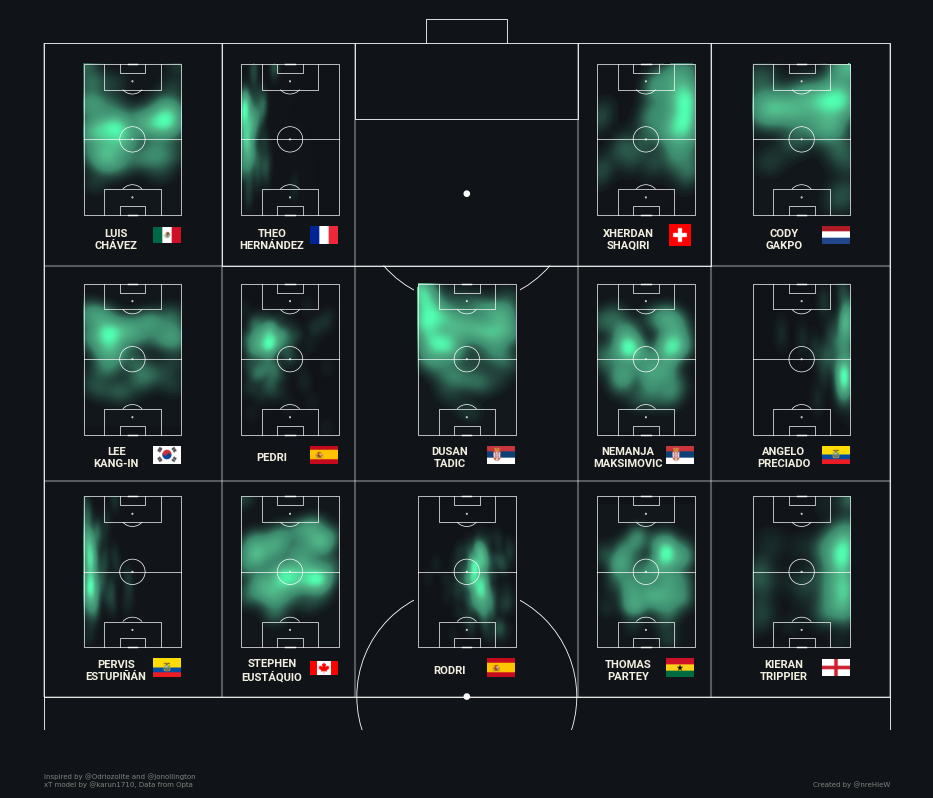

In [12]:
FONTSIZE = 8
TITLE_SIZE = 20
SUBTITLE_SIZE = 10
CREDIT_SIZE = 5
TITLEFONT ='Helvetica'
FONT = 'Roboto'
HIGHLIGHT ='#B91372'

BG_COLOR = '#101419'
POSITIONAL_COLOR = 'white'
TITLE_COLOR ='#F1EDEE'
LINECOLOR = POSITIONAL_COLOR
NOTES_COLOR = '#F3EFE0'
cmap_lst = [BG_COLOR,'#3C896D','#4FB286','#50FFB1']

plt.rcParams['figure.figsize'] = [16, 8]
pitch = VerticalPitch(half=True, pitch_type='opta',pitch_color = BG_COLOR,line_color=LINECOLOR,linewidth=0.6,goal_type='box')
fullpitch = VerticalPitch(pitch_type='opta' ,line_color=LINECOLOR,pitch_color=BG_COLOR,line_zorder=2,linewidth=0.5)
x_coord = [81.65, 64.6, 45, 25.65, 8.4] #for positioning
y_coord = [15,44.5,75]
fig, ax = pitch.draw()
fig.set_facecolor(BG_COLOR)
ax.hlines([50,66.5,83],0,100,color=POSITIONAL_COLOR,alpha=0.3)
ax.vlines([0,21.1,36.8,63.2,78.9,100],50,100,color=POSITIONAL_COLOR,alpha=0.3)
cmap=LinearSegmentedColormap.from_list('test',cmap_lst, N=256) 
for row in agg.iterrows():
    ax.text(row[1]['x_coord']+2,row[1]['y_coord']-7,row[1]['Player'].replace(' ','\n').upper(),ha='center',va='center',wrap=True,zorder=5,color = NOTES_COLOR,fontsize = FONTSIZE,
            fontfamily = FONT, fontweight = 'bold') 
    i = int(row[1]['Y_bin'])
    j = int(row[1]['X_bin'])
    if (i != 2) | (j !=2) :
        new = ax.inset_axes([x_coord[i]/100-0.06,y_coord[j]/100-0.06 + 0.02, 0.22,0.22])
        player = row[1]['Player']
        player_df = df[df['Player'] == player].T.drop_duplicates().T
        fullpitch.draw(ax = new)
        kde = fullpitch.kdeplot(player_df['X'],player_df['Y'], ax=new, shade=True, levels=200, cut=4,cmap=cmap,shade_lowest = True)
        country = df[df['Player'] == row[1]['Player']]['team'].unique()[0]
        code = flag_lookup.get(country)
        url = f'https://countryflagsapi.com/png/{country}'
        flag = ax.inset_axes([x_coord[i]/100+0.072,y_coord[j]/100-0.078 ,0.03,0.03])
        im = plt.imread(f'{code}.png')
        flag.imshow(im)
        flag.axis('off')



ax.text(0,43,'Created by @nreHieW',ha='right',fontsize = CREDIT_SIZE,va='bottom',color=NOTES_COLOR,alpha=0.5)
ax.text(100,43,'Inspired by @Odriozolite and @jonollington\nxT model by @karun1710, Data from Opta',fontsize = CREDIT_SIZE,va='bottom',color=NOTES_COLOR,alpha=0.5)
plt.savefig('GroupStagexT.jpg',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)